In [1]:
import pandas as pd
import numpy as np

import seaborn
import pandas_summary

import warnings

warnings.filterwarnings('ignore')

# Reading the data

In [2]:
df_ground = pd.read_csv('AB_NYC_2019.csv')
df_ground.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [3]:
# We'll take this data for testing later
df_no_price = df_ground[df_ground['price']==0]
df_ground = df_ground[df_ground['price']!=0]

In [4]:
df_ground.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
ground_summ = pandas_summary.DataFrameSummary(df_ground)
ground_summ.columns_stats

id         name  host_id    host_name neighbourhood_group  \
counts          48884        48868    48884        48863               48884   
uniques         48884        47894    37455        11450                   5   
missing             0           16        0           21                   0   
missing_perc       0%        0.03%       0%        0.04%                  0%   
types         numeric  categorical  numeric  categorical         categorical   

             neighbourhood latitude longitude    room_type    price  \
counts               48884    48884     48884        48884    48884   
uniques                221    19046     14715            3      673   
missing                  0        0         0            0        0   
missing_perc            0%       0%        0%           0%       0%   
types          categorical  numeric   numeric  categorical  numeric   

             minimum_nights number_of_reviews  last_review reviews_per_month  \
counts                48884             48884        38833             38833   
uniques                 109               394         1764               937   
missing                   0                 0        10051             10051   
missing_perc             0%                0%       20.56%            20.56%   
types               numeric           numeric  categorical           numeric   

             calculated_host_listings_count availability_365  
counts                                48884            48884  
uniques                                  47              366  
missing                                   0                0  
missing_perc                             0%               0%  
types                               numeric          numeric

In [6]:
df = df_ground.copy()

# Clean the nans in host_name
df.loc[pd.isnull(df['host_name']), 'host_name'] = 'Someone'

# Clean nans in reviews
df.loc[df['number_of_reviews']==0, 'last_review'] = pd.to_datetime('01/01/2010')
df.loc[df['number_of_reviews']==0, 'reviews_per_month'] = 0

In [7]:
df['room_type_cat'] = df['room_type'].astype('category')
df['last_review'] = pd.to_datetime(df['last_review'])
df['neighbourhood_cat'] = df['neighbourhood'].astype('category')
df['neighbourhood_cat'] = df['neighbourhood_group'].astype('category')

### Feature engineering
We could use the number of hosts as a new parametter.

Usuall with more than one name we have ' And ', ' Or ' and ' & ' in it.

In [8]:
# Checking wich failing parametters do we have.
for x in df['host_name']:
    if len(str(x).split(' ')) > 1:
        # if ' And ' in x:
        # if ' Or ' in x:
        # if ' & ' in x:
        # if ' And ' in x and ' & ' in x:
        # if ' Or ' in x and ' & ' in x:
            # print(x)
        pass

In [9]:
def replace_hosts_by_number_of_hosts(x):
    x = str(x)
    y = 0
    if ' & ' in x:
        y = len(x.split(','))+1
    elif ' And ' in x:
        y += len(x.split(','))+1
    elif '& Kim And' in x:
        y = 3
    elif ' Or ' in x:
        y = 2
    else:
        y = 1
    return y
    
df['host_quant'] = df['host_name'].apply(replace_hosts_by_number_of_hosts)

In [10]:
# Changing number of days of the year that it's aviable for months:
def get_num_months(x):
    return x/(365.2425/12);

df['availability_365'].apply(get_num_months)

0        11.992033
1        11.663484
2        11.992033
3         6.373848
4         0.000000
           ...    
48890     0.295694
48891     1.182776
48892     0.887082
48893     0.065710
48894     0.755662
Name: availability_365, Length: 48884, dtype: float64

In [11]:
df['room_type_cat_codes'] = df['room_type_cat'].cat.codes
df['neighbourhood_cat_codes'] = df['neighbourhood_cat'].cat.codes
delete_column_list = ['id', 'host_id', 'host_name', 'name', 'neighbourhood_group', 'neighbourhood',
                      'neighbourhood_cat', 'room_type', 'room_type_cat']
df_new = df[[x for x in df.columns if x not in delete_column_list]]
df_new.dtypes

latitude                                 float64
longitude                                float64
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
host_quant                                 int64
room_type_cat_codes                         int8
neighbourhood_cat_codes                     int8
dtype: object

In [12]:
df_new_summ = pandas_summary.DataFrameSummary(df_new)
df_new_summ.columns_stats

latitude longitude    price minimum_nights number_of_reviews  \
counts          48884     48884    48884          48884             48884   
uniques         19046     14715      673            109               394   
missing             0         0        0              0                 0   
missing_perc       0%        0%       0%             0%                0%   
types         numeric   numeric  numeric        numeric           numeric   

             last_review reviews_per_month calculated_host_listings_count  \
counts             48884             48884                          48884   
uniques             1765               938                             47   
missing                0                 0                              0   
missing_perc          0%                0%                             0%   
types               date           numeric                        numeric   

             availability_365 host_quant room_type_cat_codes  \
counts                  48884      48884               48884   
uniques                   366          4                   3   
missing                     0          0                   0   
missing_perc               0%         0%                  0%   
types                 numeric    numeric             numeric   

             neighbourhood_cat_codes  
counts                         48884  
uniques                            5  
missing                            0  
missing_perc                      0%  
types                        numeric

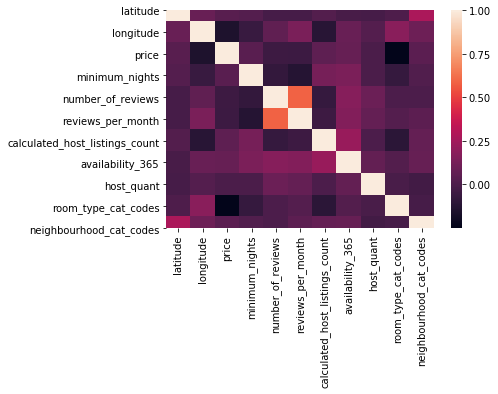

In [13]:
seaborn.heatmap(df_new.corr())

In [14]:
df_ground['calculated_host_listings_count'].unique()

array([  6,   2,   1,   4,   3,   5,   7,  13,  28,  11,   8,   9,  52,
        18,  15,  19,  10,  39,  26,  29,  12,  21,  96,  14,  34,  43,
       121,  37,  49,  31,  91,  16,  87,  33,  23,  50,  20,  25, 232,
        17,  47, 103,  65,  30,  27, 327,  32], dtype=int64)

In [ ]:
# Using keras

In [15]:
import tensorflow as tf
# tensorflow is crashing..
# https://www.tensorflow.org/tutorials/estimator/premade

In [109]:
# Split the data in train-test
df_train = df_new[0:40000]
df_test = df_new[40000:df_new.shape[0]]
colmuns_without_price = [x for x in df_train.columns if x != 'price']
df_test = df_test[colmuns_without_price]

In [47]:
df_train.shape

(40000, 12)

In [48]:
df_test.shape

(8884, 11)

In [49]:
print(f'{df_new.shape[0]} = {df_train.shape[0]} + {df_test.shape[0]}')

48884 = 40000 + 8884


In [60]:
# Input function for dataset [https://www.tensorflow.org/tutorials/estimator/premade]
def input_evaluation_set(df):
    features = {}
    for x in df.columns:
        features[x] = df[x].values
    labels = np.array((df.index))
    return features, labels

In [86]:
# Feature columns
def get_feature_columns(df, not_feature_column):
    my_feature_columns = []
    for x in [x for x in df.columns if x != not_feature_column]:
        my_feature_columns.append(tf.feature_column.numeric_column(key=x))
    return my_feature_columns

In [104]:
input_features, input_labels = input_evaluation_set(df_train)
my_feature_columns = get_feature_columns(df_train, 'price')

In [105]:
print(max(df_train['price']))
print(min(df_train['price']))


10000
10


In [106]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=990)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Usuario\\AppData\\Local\\Temp\\tmp4jn1er9u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000028B342220F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [103]:
1000-10

990

In [110]:
classifier.train(
    input_fn=lambda: input_evaluation_set(df_train, df_train[colmuns_without_price], training=True),
    steps=5000)


TypeError: input_evaluation_set() got an unexpected keyword argument 'training'